In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import DOMWidget, widget_serialization
from matplotlib import is_interactive, rcParams
from matplotlib._pylab_helpers import Gcf
from matplotlib.backend_bases import NavigationToolbar2, _Backend, cursors
from matplotlib.backends.backend_webagg_core import (
    FigureCanvasWebAggCore,
    FigureManagerWebAgg,
    NavigationToolbar2WebAgg,
    TimerTornado,
)
%matplotlib
import ipympl



Using matplotlib backend: module://matplotlib_inline.backend_inline


ValueError: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline', 'module://matplotlib_inline.backend_inline']

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('sweep.csv')

# Extract real and imaginary parts
real = df['Real']
imaginary = df['Imaginary']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(real, linestyle='-', color='b')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


In [24]:
! make && sudo ./sdr-config --test configs/config.xml

[100%] Built target sdr-config
XML parse result: No error
Device configured as TX and RX
Performing test: RX_TEST
[INFO] [UHD] linux; GNU C++ version 11.4.0; Boost_107400; UHD_4.7.0.0-0-ga5ed1872
type=usrp2,addr=192.168.10.2,name=,serial=E4R10Z8UN
[INFO] [USRP2] Opening a USRP2/N-Series device...
[INFO] [USRP2] Current recv frame size: 1472 bytes
[INFO] [USRP2] Current send frame size: 1472 bytes
[INFO] [USRP2] Detecting internal GPSDO.... 
[INFO] [GPS] Found an internal GPSDO: Jackson-Labs, FireFly , Firmware Rev 0.923
[INFO] [USRP2] Setting references to the internal GPSDO
RuntimeError: NotImplementedError: get_rx_power_range() not available for this device and channel
RuntimeError: NotImplementedError: get_tx_power_range() not available for this device and channel
Default (current) clock source: gpsdo
Default (current) time source: gpsdo
Setting TX Rate (MHz):  25
Setting TX bandwidth (MHz):  0.35
Setting TX center freq (MHz):  900
Setting TX Gain (dB) : 0
Actual TX Gain (dB) : 0. O

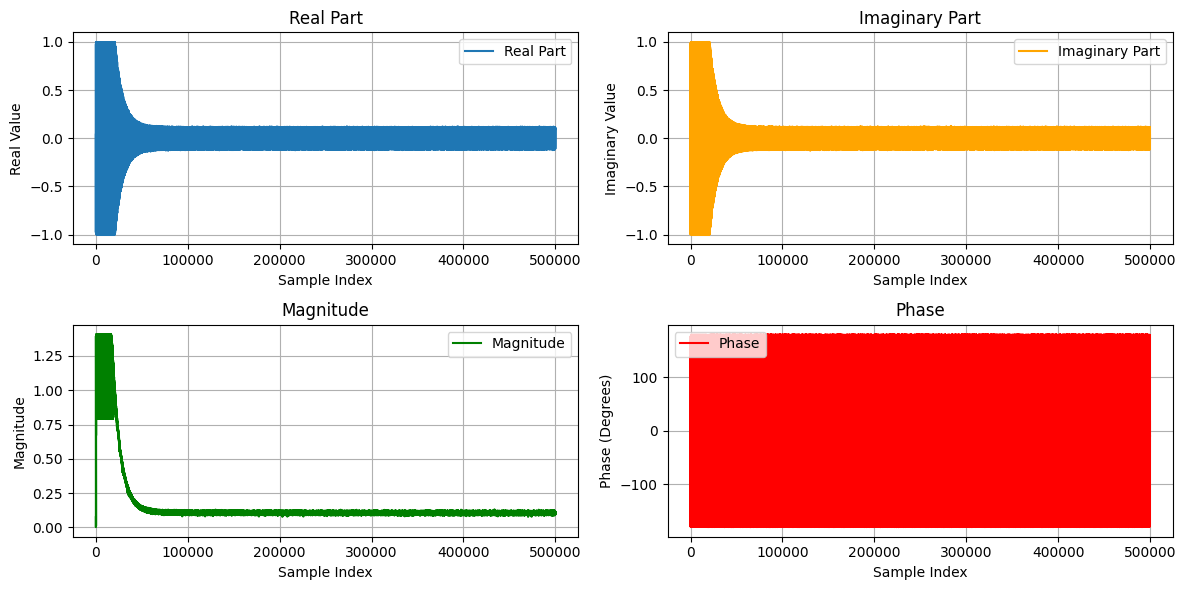

500000


In [26]:


# Define the path to your binary file
file_path = 'rx_test.bin'


# Read the binary file
with open(file_path, 'rb') as file:
    # Read the data into a numpy array
    # The dtype should match the type of data in the file (double = float64)
    data = np.fromfile(file, dtype=np.float64)

# Reshape or process the data if needed
# Here we assume data was written as 2 doubles per sample
num_new_samples = int(len(data)/2)
data = data.reshape((num_new_samples, 2))


# Create complex numbers from the real and imaginary parts
complex_data = data[:, 0] + 1j * data[:, 1]

fft_data = np.fft.fftshift(np.fft.fft(complex_data))

# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
axs[0, 0].plot(np.real(complex_data), label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

print(num_new_samples)

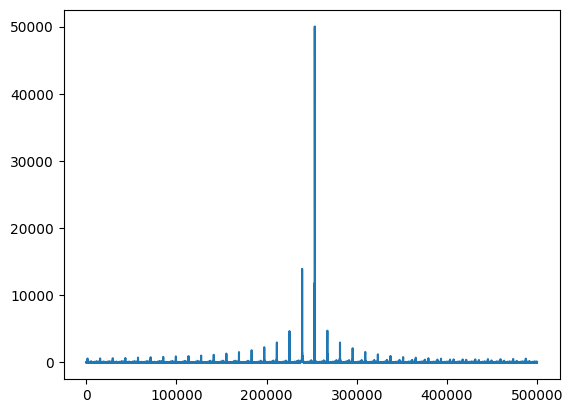

In [29]:
plt.plot(abs(fft_data))
plt.show()